In [26]:
import numpy as np
import matplotlib.pyplot as plt
import folie as fl
import csv
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy


1D UNBIASED Double Well Potential
==

## 1) The model 


Here we model the double well potential as a quartic function $V(q)= \sum_{i=0}^4 c_iq^i$ and choose a constant diffusion coefficient $D(q)=q$ :

The force parameter to pass to the simulator will then be : $F = - \frac{dV(q)}{dq}$

In [2]:
coeff=0.1*np.array([0,0,-4.5,0,0.1]) # coefficients of the free energy
free_energy = np.polynomial.Polynomial(coeff)
force_coeff=np.array([-coeff[1],-2*coeff[2],-3*coeff[3],-4*coeff[4]]) #coefficients of the free energy
force_function = fl.functions.Polynomial(deg=3,coefficients=force_coeff)
diff_function= fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.5]))

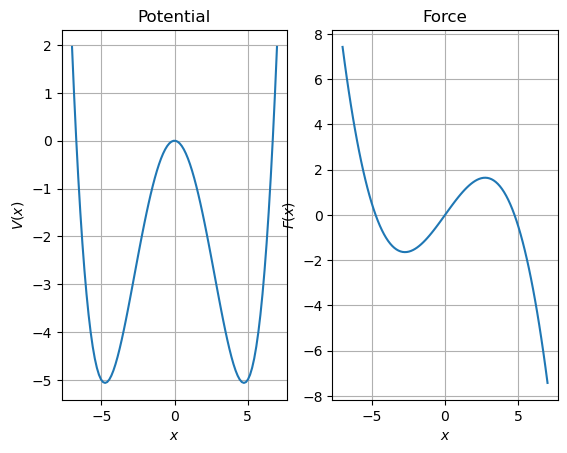

In [3]:
# Plot of Free Energy and Force
x_values = np.linspace(-7, 7, 100)
fig, axs = plt.subplots(1, 2)
axs[0].plot(x_values,free_energy(x_values))
axs[1].plot(x_values,force_function(x_values.reshape(len(x_values),1)))
axs[0].set_title("Potential")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$V(x)$")
axs[0].grid()
axs[1].set_title("Force") 
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$F(x)$") 
axs[1].grid()

## 2) Simulation

In [4]:
# Define model to simulate and type of simulator to use
dt=1e-3
model_simu = fl.models.overdamped.Overdamped(force_function,diffusion=diff_function)
simulator = fl.simulations.Simulator(fl.simulations.EulerStepper(model_simu), dt) #, k=0.0, xstop=6.0)

In [5]:
ntraj=30
q0= np.empty(ntraj)
for i in range(len(q0)):
    q0[i]=0
# Calculate Trajectory
time_steps=10000
data = simulator.run(time_steps, q0, 1)

In [24]:
len(data)

30

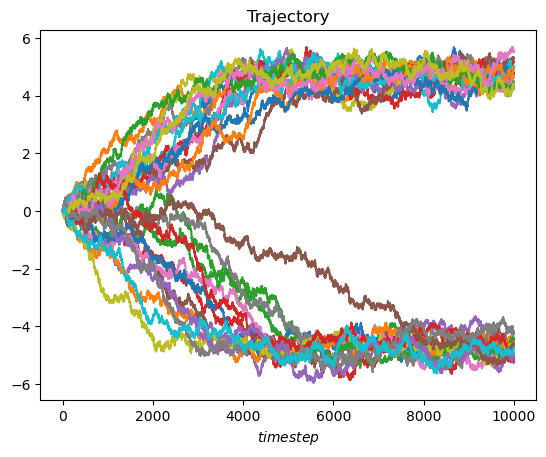

In [6]:
# Plot the trajecories
fig, axs = plt.subplots(1,1)
for n, trj in enumerate(data):
    axs.plot(trj["x"])
    axs.set_title("Trajectory")
    axs.set_xlabel("$timestep$")

## 3) Model Training 

#\# Parameters of the training
trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
#\# trainmodel=fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=False)
trainmodel= fl.models.OverdampedSplines1D(domain=domain)

fig, axs = plt.subplots(1, 2)
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$")
axs[1].grid()


xfa = np.linspace(-7.0, 7.0, 75)

axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)), label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")
for name, transitioncls in zip(
    ["Euler", "Ozaki", "ShojiOzaki", "Elerian", "Kessler", "Drozdov"],
    [
        fl.EulerDensity,
        fl.OzakiDensity,
        fl.ShojiOzakiDensity,
        fl.ElerianDensity,
        fl.KesslerDensity,
        fl.DrozdovDensity,
    ],
):
    estimator = fl.LikelihoodEstimator(transitioncls(fl.models.OverdampedSplines1D(domain=domain)))
    res = estimator.fit_fetch(data)
    print(res.coefficients)
    # res.remove_bias()
    axs[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    axs[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
axs[0].legend()
axs[1].legend()
plt.show()

### 3.1) Training using same functional form of true force and diffusion 

In [ ]:
# Parameters of the training
trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))

trainmodel=fl.models.Overdamped(force = trainforce,diffusion=traindiff)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))  # deepcopy is used because the estimator modifies the model when fit method is called
Ozk_estimator = fl.LikelihoodEstimator(fl.OzakiDensity(deepcopy(trainmodel)))  # and when the second estimator uses the object trainmodel this will already have the modfications
Shj_estimator = fl.LikelihoodEstimator(fl.ShojiOzakiDensity(deepcopy(trainmodel))) # made by the previuos estimatorand so in the end they will return the exact same results
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))  # which is the reason why the loop checking if the values are different in the following cell exists
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel)))
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel)))

Eul_res=Eul_estimator.fit_fetch(data)
Ozk_res=Ozk_estimator.fit_fetch(data)
Shj_res=Shj_estimator.fit_fetch(data)
Eln_res=Eln_estimator.fit_fetch(data)
Ksl_res=Ksl_estimator.fit_fetch(data)
Drz_res=Drz_estimator.fit_fetch(data)

res_vec = [Eul_res,Ozk_res,Shj_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 


/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:191: RuntimeWarning: invalid value encountered in sqrt
  Vt = np.sqrt(sig * (np.exp(Kt * dt) - 1) / Kt)
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:190: RuntimeWarning: invalid value encountered in log
  Kt = (2 / dt) * np.log(1 + temp / x.ravel())
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:212: RuntimeWarning: invalid value encountered in sqrt
  sig = np.sqrt(self._model.diffusion(x, **kwargs).ravel())
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:221: RuntimeWarning: overflow encountered in exp
  B = sig * np.sqrt((np.exp(2 * Lt * dt) - 1) / (2 * Lt))
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:223: RuntimeWarning: overflow encountered in exp
  elt = np.exp(Lt * dt) - 1
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:224: RuntimeWarning: overflow encountered in multiply
  A = x.ravel() + mu /

[ 0.12326394  0.92978574 -0.00912699 -0.04178302  0.50116262]
[ 1.23533140e-04  9.29629983e-04 -9.14577286e-06 -4.17755609e-05
  5.01926907e-01]
[ 1.23533140e-04  9.29629983e-04 -9.14577286e-06 -4.17755609e-05
  5.01926907e-01]
[ 0.12325752  0.92981884 -0.00912754 -0.04178445  0.50116317]
[ 0.12280816  0.9281888  -0.00910943 -0.04171053  0.50166357]
[ 0.12319667  0.9293784  -0.00912934 -0.04176292  0.50166507]


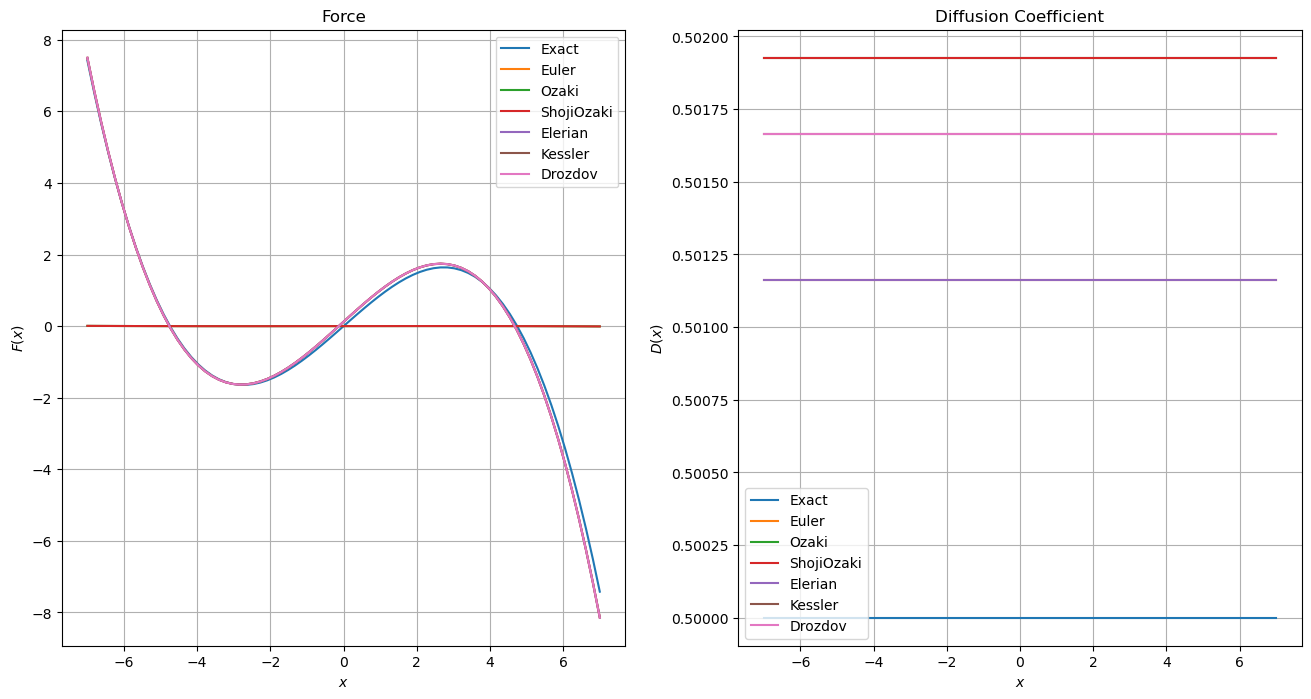

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()
xfa = np.linspace(-7.0, 7.0, 75)

#Plot exact quantities 
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)), label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")
#Plot inferred quantities 
names = ["Euler", "Ozaki", "ShojiOzaki", "Elerian", "Kessler", "Drozdov"]
for i in range(len(names)):
    axs[0].plot(xfa, res_vec[i].force(xfa.reshape(-1, 1)), label=names[i] )
    axs[1].plot(xfa, res_vec[i].diffusion(xfa.reshape(-1, 1)), label=names[i])
    print(res_vec[i].coefficients)
axs[0].legend()
axs[1].legend()



Check if the methods are returning all the the same results

In [ ]:
for i in range(len(names)-1):
    flag_force= (res_vec[i].force(xfa.reshape(-1, 1)) == res_vec[i+1].force(xfa.reshape(-1, 1))).all()
    flag_diff= (res_vec[i].diffusion(xfa.reshape(-1, 1)) == res_vec[i+1].diffusion(xfa.reshape(-1, 1))).all()
    print(flag_force, flag_diff)  # apparently they are 

False False
True True
False False
False False
False False


### 3.2) Training using splines

In [8]:
# Parameters of the training

domain = fl.MeshedDomain.create_from_range(np.linspace(data.stats.min , data.stats.max , 10).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))
Ozk_estimator = fl.LikelihoodEstimator(fl.OzakiDensity(deepcopy(trainmodel)))
Shj_estimator = fl.LikelihoodEstimator(fl.ShojiOzakiDensity(deepcopy(trainmodel)))
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel)))
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel)))

Eul_res=Eul_estimator.fit_fetch(data)
Ozk_res=Ozk_estimator.fit_fetch(data)
Shj_res=Shj_estimator.fit_fetch(data)
Eln_res=Eln_estimator.fit_fetch(data)
Ksl_res=Ksl_estimator.fit_fetch(data)
Drz_res=Drz_estimator.fit_fetch(data)

res_vec = [Eul_res,Ozk_res,Shj_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 


/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:191: RuntimeWarning: invalid value encountered in sqrt
  Vt = np.sqrt(sig * (np.exp(Kt * dt) - 1) / Kt)
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:190: RuntimeWarning: invalid value encountered in log
  Kt = (2 / dt) * np.log(1 + temp / x.ravel())
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:212: RuntimeWarning: invalid value encountered in sqrt
  sig = np.sqrt(self._model.diffusion(x, **kwargs).ravel())
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:221: RuntimeWarning: overflow encountered in exp
  B = sig * np.sqrt((np.exp(2 * Lt * dt) - 1) / (2 * Lt))
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:223: RuntimeWarning: overflow encountered in exp
  elt = np.exp(Lt * dt) - 1
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:224: RuntimeWarning: overflow encountered in multiply
  A = x.ravel() + mu /

In [ ]:
res_vec[].force

SyntaxError: invalid syntax (181384796.py, line 1)

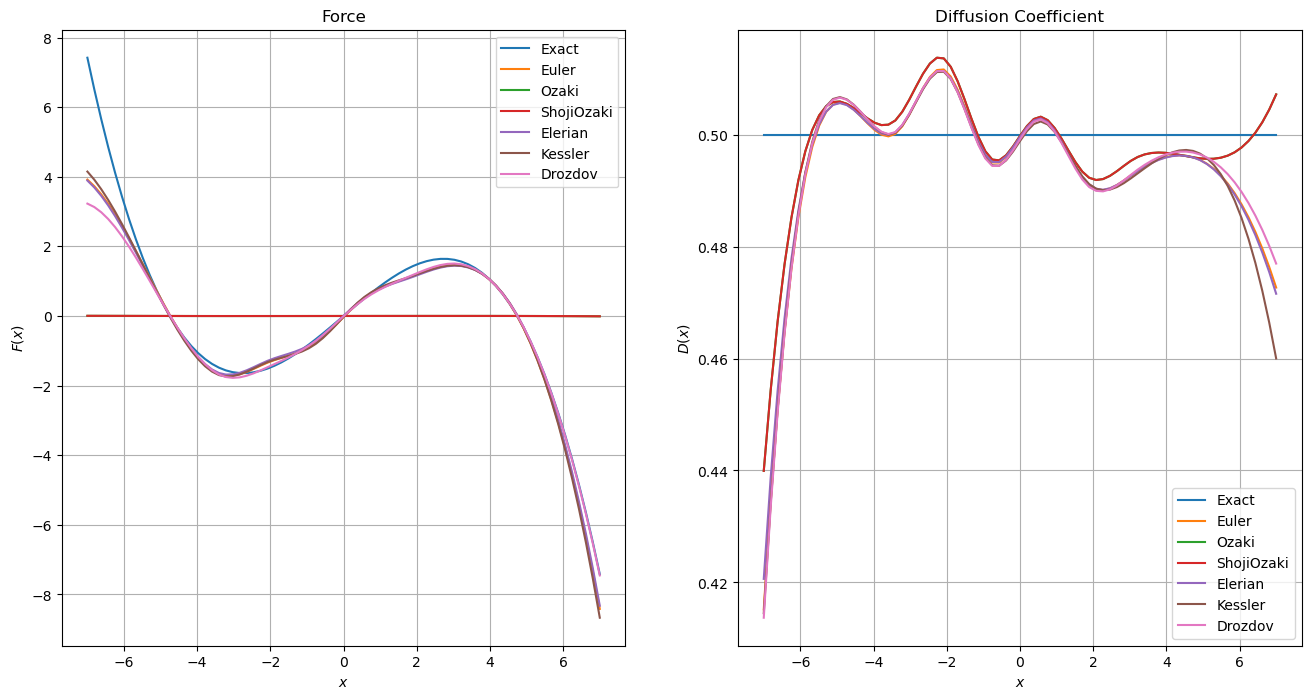

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
# axs.set_title("training using splines and 30 trajectories ")
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()
xfa = np.linspace(-7.0, 7.0, 75)

#Plot exact quantities 
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)), label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")
#Plot inferred quantities 
names = ["Euler", "Ozaki", "ShojiOzaki", "Elerian", "Kessler", "Drozdov"]
for i in range(len(names)):
    axs[0].plot(xfa, res_vec[i].force(xfa.reshape(-1, 1)), label=names[i] )
    axs[1].plot(xfa, res_vec[i].diffusion(xfa.reshape(-1, 1)), label=names[i])
axs[0].legend()
axs[1].legend()

Check if the methods are returning all the the same results

In [ ]:
for i in range(len(names)-1):
    flag_force= (res_vec[i].force(xfa.reshape(-1, 1)) == res_vec[i+1].force(xfa.reshape(-1, 1))).all()
    flag_diff= (res_vec[i].diffusion(xfa.reshape(-1, 1)) == res_vec[i+1].diffusion(xfa.reshape(-1, 1))).all()
    print(flag_force, flag_diff)  # apparently they are 

False False
True True
False False
False False
False False


[ 5.93779812 21.61172333 21.61172333  6.16690615  6.46510623  6.41053799]


False

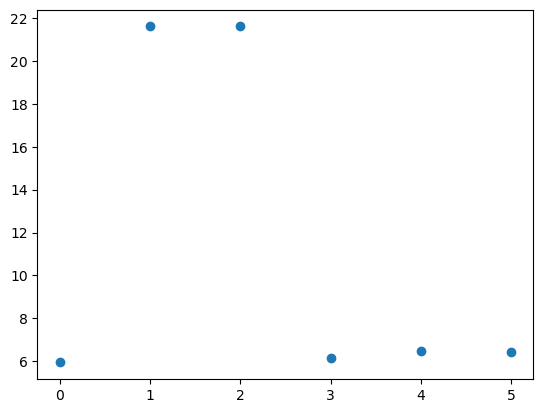

In [ ]:
rmsd_force=np.array([ np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Eul_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Ozk_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Shj_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Eln_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Ksl_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Drz_res.force(xfa.reshape(-1, 1)))  ])

rmsd_diffusion=np.array([np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Eul_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Ozk_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Shj_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Eln_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Ksl_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Drz_res.diffusion(xfa.reshape(-1, 1)))  ])

# plt.scatter(np.arange(len(rmsd_force)),rmsd_force)

plt.scatter(np.arange(len(rmsd_force)),rmsd_force)
print(rmsd_force)
flag =True
for i in range(len(rmsd_force)-1):
    if rmsd_force[i] != rmsd_force[i+1]:
        flag = False
flag

1D BIASED Double Well Potential
==

## 1) Model

Here we model the double well potential as a quartic function $V(q)= \sum_{i=0}^4 c_iq^i$ and choose a constant diffusion coefficient $D(q)=D$ : $\newline$
The force parameter to pass to the simulator will then be : $F = - \frac{dV(q)}{dq}$   $\newline$
Adiabaic bias used : $V_{bias}(q)=\frac{1}{2}k(q-q_0)^2  \longmapsto$ ABMD_Simulator $\newline$
The center of the parabola, $q_0$, is choosen as : $max(q,q_0)$ at every iteration 

In [ ]:
coeff=0.1*np.array([0,0,-4.5,0,0.1]) # coefficients of the free energy
free_energy = np.polynomial.Polynomial(coeff)
force_coeff=np.array([-coeff[1],-2*coeff[2],-3*coeff[3],-4*coeff[4]]) #coefficients of the free energy
force_function = fl.functions.Polynomial(deg=3,coefficients=force_coeff)
diff_function= fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.5]))

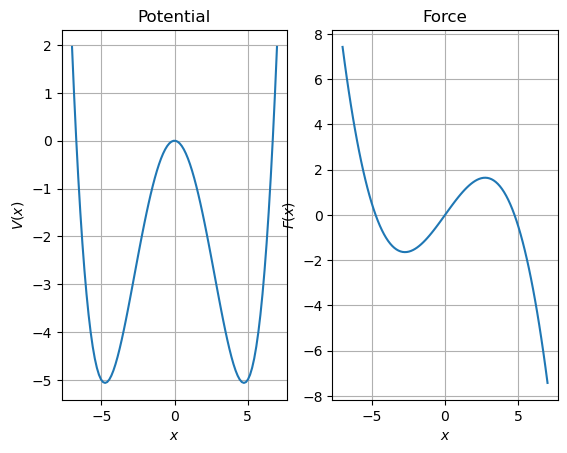

In [ ]:
# Plot of Free Energy and Force
x_values = np.linspace(-7, 7, 100)
fig, axs = plt.subplots(1, 2)
axs[0].plot(x_values,free_energy(x_values))
axs[1].plot(x_values,force_function(x_values.reshape(len(x_values),1)))
axs[0].set_title("Potential")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$V(x)$")
axs[0].grid()
axs[1].set_title("Force") 
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$F(x)$") 
axs[1].grid()

## 2) Simulation

In [ ]:
# Define model to simulate and type of simulator to use
dt=1e-3
biased_model_simu = fl.models.overdamped.Overdamped(force_function,diffusion=diff_function)
biased_simulator = fl.simulations.ABMD_Simulator(fl.simulations.EulerStepper(biased_model_simu), dt, k=5.0, xstop=6.0) 
ntraj=30
q0= np.empty(ntraj)
for i in range(len(q0)):
    q0[i]=0
# Calculate Trajectory
time_steps=5000
biased_data = biased_simulator.run(time_steps, q0, 1)
xmax = np.concatenate(biased_simulator.xmax_hist, axis=1).T    # if you rerun simulator.run without reinializing the simulator object it will probably append the results making xmax twice as long 

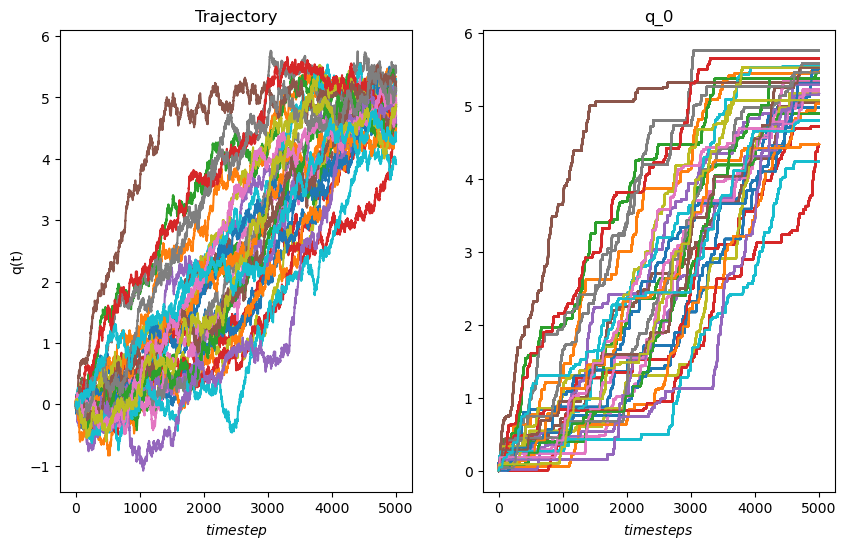

In [ ]:
# Plot the trajecories
fig, axs = plt.subplots(1,2,figsize=(10,6))
for n, trj in enumerate(biased_data):
    axs[0].plot(trj["x"])
    axs[0].set_title("Trajectory")
    axs[0].set_xlabel("$timestep$")
    axs[0].set_ylabel("q(t)")
    axs[1].plot(xmax)
    axs[1].set_title("q_0")
    axs[1].set_xlabel("$timesteps$")



## 3) Model Training 

### 3.1) Training using same functional form of true force and diffusion 

In [ ]:
# Parameters of the training

trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
trainmodel=fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=True)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))
Ozk_estimator = fl.LikelihoodEstimator(fl.OzakiDensity(deepcopy(trainmodel)))
Shj_estimator = fl.LikelihoodEstimator(fl.ShojiOzakiDensity(deepcopy(trainmodel)))
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel)))
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel)))

Eul_res=Eul_estimator.fit_fetch(data)
Ozk_res=Ozk_estimator.fit_fetch(data)
Shj_res=Shj_estimator.fit_fetch(data)
Eln_res=Eln_estimator.fit_fetch(data)
Ksl_res=Ksl_estimator.fit_fetch(data)
Drz_res=Drz_estimator.fit_fetch(data)

Eul_res.remove_bias()
Ozk_res.remove_bias()
Shj_res.remove_bias()
Eln_res.remove_bias()
Ksl_res.remove_bias()
Drz_res.remove_bias()

res_vec = [Eul_res,Ozk_res,Shj_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 


RecursionError: maximum recursion depth exceeded

In [ ]:
# trainmodel_simu = biased_model_simu
# trainmodel_simu.remove_bias()

Model is not biased


TypeError: FunctionOffset.__call__() missing 1 required positional argument: 'v'

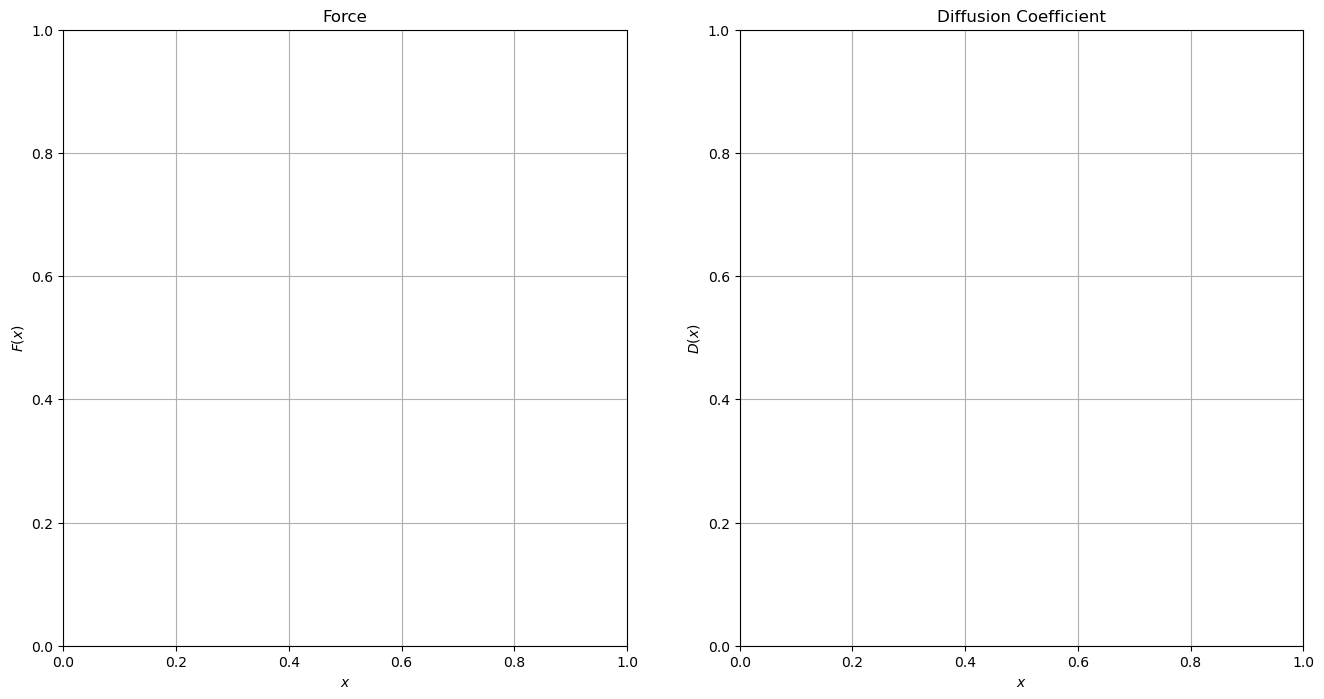

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()
xfa = np.linspace(-7.0, 7.0, 75)

#Plot exact quantities 
axs[0].plot(xfa, biased_model_simu.force(xfa.reshape(-1, 1)), label="Exact")
axs[1].plot(xfa, biased_model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")
#Plot inferred quantities 
names = ["Euler", "Ozaki", "ShojiOzaki", "Elerian", "Kessler", "Drozdov"]
for i in range(len(names)):
    axs[0].plot(xfa, res_vec[i].force(xfa.reshape(-1, 1)), label=names[i] )
    axs[1].plot(xfa, res_vec[i].diffusion(xfa.reshape(-1, 1)), label=names[i])
axs[0].legend()
axs[1].legend()


In [ ]:

rmsd_force=np.array([ np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Eul_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Ozk_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Shj_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Eln_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Ksl_res.force(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.force(xfa.reshape(-1, 1))-Drz_res.force(xfa.reshape(-1, 1)))  ])

rmsd_diffusion=np.array([np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Eul_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Ozk_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Shj_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Eln_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Ksl_res.diffusion(xfa.reshape(-1, 1))),
                        np.linalg.norm(model_simu.diffusion(xfa.reshape(-1, 1))-Drz_res.diffusion(xfa.reshape(-1, 1)))  ])

# plt.scatter(np.arange(len(rmsd_force)),rmsd_force)

plt.scatter(np.arange(len(rmsd_diffusion)),rmsd_diffusion)
print(rmsd_diffusion)

TypeError: FunctionOffset.__call__() missing 1 required positional argument: 'v'

### 3.2) Training using splines

In [ ]:
# Parameters of the training

domain = fl.MeshedDomain.create_from_range(np.linspace(data.stats.min , data.stats.max , 10).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(trainmodel))
Ozk_estimator = fl.LikelihoodEstimator(fl.OzakiDensity(trainmodel))
Shj_estimator = fl.LikelihoodEstimator(fl.ShojiOzakiDensity(trainmodel))
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(trainmodel))
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(trainmodel))
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(trainmodel))

Eul_res=Eul_estimator.fit_fetch(data)
Ozk_res=Ozk_estimator.fit_fetch(data)
Shj_res=Shj_estimator.fit_fetch(data)
Eln_res=Eln_estimator.fit_fetch(data)
Ksl_res=Ksl_estimator.fit_fetch(data)
Drz_res=Drz_estimator.fit_fetch(data)

res_vec = [Eul_res,Ozk_res,Shj_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 


/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:191: RuntimeWarning: invalid value encountered in sqrt
  Vt = np.sqrt(sig * (np.exp(Kt * dt) - 1) / Kt)
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:190: RuntimeWarning: invalid value encountered in log
  Kt = (2 / dt) * np.log(1 + temp / x.ravel())
/home/dbersano/folie/folie/estimation/transitionDensity.py:11: RuntimeWarning: overflow encountered in square
  return -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:212: RuntimeWarning: invalid value encountered in sqrt
  sig = np.sqrt(self._model.diffusion(x, **kwargs).ravel())
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:221: RuntimeWarning: overflow encountered in exp
  B = sig * np.sqrt((np.exp(2 * Lt * dt) - 1) / (2 * Lt))
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:223: RuntimeWarning: overflow 

# 2D UNBIASED Double Well Potential

## 1) The Model

Here we model the double well potential as a quartic function along x  and a parabola along y $V(x,y)= a(x^2-1)^2 + \frac{1}{2}by^2$
and constant diffusion matrix $D= d\begin{bmatrix} 1 \ \ 0 \\\ 0 \ \ 1 \end{bmatrix}$

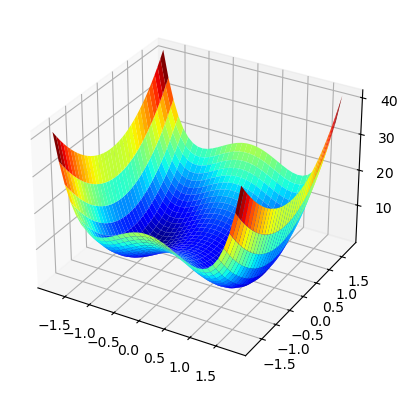

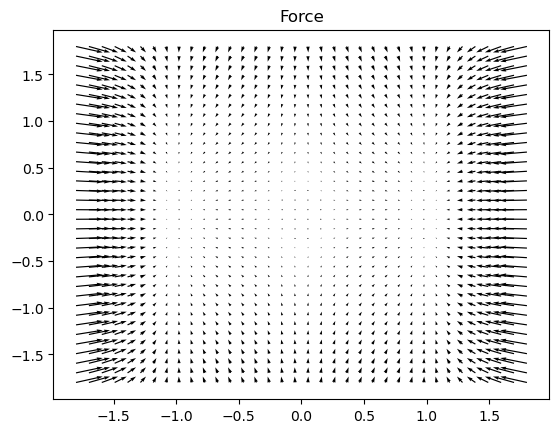

In [27]:
x = np.linspace(-1.8,1.8,36)
y = np.linspace(-1.8,1.8,36)
input=np.transpose(np.array([x,y]))

diff_function= fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.5]) * np.eye(2,2))
a,b = 5.0, 10.0
quartic2d= fl.functions.Quartic2D(a=a,b=b)
exx = fl.functions.analytical.My_Quartic2D(a=a,b=b)

X,Y =np.meshgrid(x,y)

# Plot potential surface 
pot = exx.potential(X,Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,pot, rstride=1, cstride=1,cmap='jet', edgecolor = 'none')

# Plot Force function
ff=quartic2d.force(input) # returns x and y components of the force : x_comp =ff[:,0] , y_comp =ff[:,1]
U,V = np.meshgrid(ff[:,0],ff[:,1])
fig, ax =plt.subplots()
ax.quiver(x,y,U,V)
ax.set_title('Force')
# plt.show()
print(quartic2d.domain)
fff=fl.functions.Quartic2DForce(exx.force, dim=2)

## 2) Simulation

In [28]:
dt = 1e-3
model_simu=fl.models.overdamped.Overdamped(force=quartic2d,diffusion=diff_function)
simulator=fl.simulations.Simulator(fl.simulations.EulerStepper(model_simu), dt)


In [29]:
# initialize positions 
ntraj=50
q0= np.empty(shape=[ntraj,2])
for i in range(ntraj):
    for j in range(2):
        q0[i][j]=0.000
time_steps=5000
data = simulator.run(time_steps, q0,save_every=1)  

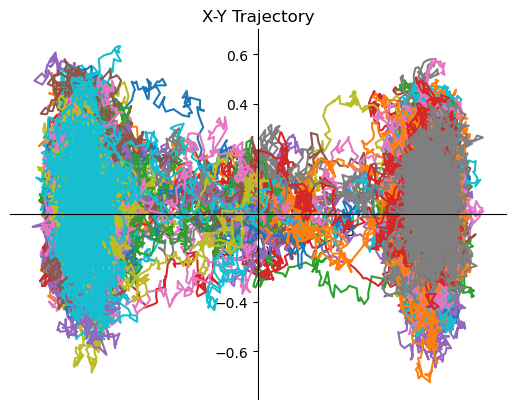

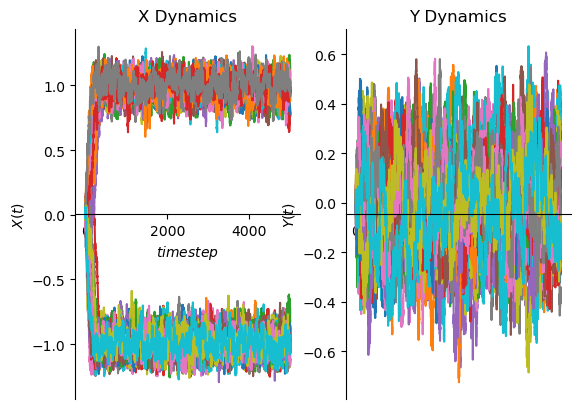

In [30]:
# Plot the resulting trajectories
fig, axs = plt.subplots()
for n, trj in enumerate(data):
    axs.plot(trj["x"][:,0],trj["x"][:,1])
    axs.spines['left'].set_position('center')
    axs.spines['right'].set_color('none')
    axs.spines['bottom'].set_position('center')
    axs.spines['top'].set_color('none')
    axs.xaxis.set_ticks_position('bottom')
    axs.yaxis.set_ticks_position('left')
    axs.set_xlabel("$X(t)$")
    axs.set_ylabel("$Y(t)$")
    axs.set_title("X-Y Trajectory")
    axs.grid()

"""fig, axs = plt.subplots(1,2)
for n, trj in enumerate(data):
    axs[0].plot(trj["x"][:,0],trj["x"][:,1])
    #axs[1].plot(xmax[:, n])
    axs[1].set_xlabel("$timestep$")
    axs[1].set_ylabel("$x(t)$")
    axs[1].grid()"""
# plot x,y Trajectories in separate subplots
fig,bb =  plt.subplots(1,2)
for n, trj in enumerate(data):
    bb[0].plot(trj["x"][:,0])
    bb[1].plot(trj["x"][:,1])

# Set visible  axis
    bb[0].spines['right'].set_color('none')
    bb[0].spines['bottom'].set_position('center')
    bb[0].spines['top'].set_color('none')
    bb[0].xaxis.set_ticks_position('bottom')
    bb[0].yaxis.set_ticks_position('left')
    bb[0].set_xlabel("$timestep$")
    bb[0].set_ylabel("$X(t)$")

# Set visible axis
    bb[1].spines['right'].set_color('none')
    bb[1].spines['bottom'].set_position('center')
    bb[1].spines['top'].set_color('none')
    bb[1].xaxis.set_ticks_position('bottom')
    bb[1].yaxis.set_ticks_position('left')
    bb[1].set_xlabel("$timestep$")
    bb[1].set_ylabel("$Y(t)$")

    bb[0].set_title("X Dynamics")
    bb[1].set_title("Y Dynamics")

## 3) Fitting 

### 3.1) Projecting onto the x Coordinate 


In [95]:
xdata = fl.data.trajectories.Trajectories(dt=dt) 
s = np.empty(shape=(len(trj["x"][:,0]),1))
for n, trj in enumerate(data):
    for j in range(len(trj["x"][:,0])):
        s[j]=trj["x"][:,0][j]
    xdata.append(s)
print(len(s))
# #### Possible models 
# trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
# traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
# trainmodelx=fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=False)
xfa = np.linspace(-1.3, 1.3, 75)
xforce = -4*a*(xfa** 3 - xfa)

4999


#### 3.1.1) Fitting with exact model

[ -5.99748328   9.76122359   0.81160255 -14.91665018   0.80387012
   1.49605812   2.1861553    0.9809239 ]
[ -5.99748319   9.76122359   0.81160253 -14.91665017   0.80386988
   1.49605835   2.18615532   0.98092366]
[ -5.99748949   9.76103449   0.81194743 -14.9171452    0.8029246
   1.49126202   2.19300266   0.97284855]
[ -5.99749459   9.76105872   0.81193341 -14.91714613   0.80230969
   1.49147898   2.19332475   0.97176712]


Text(0.5, 0.98, ' Order 3 Polynomial fitting along x direction')

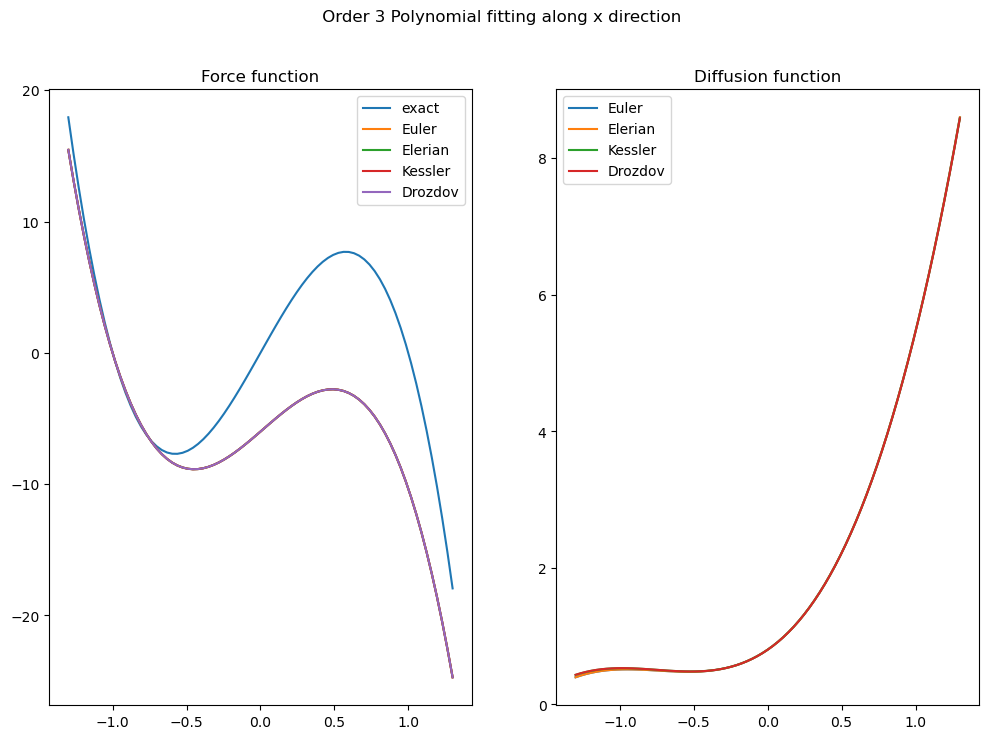

In [101]:
trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
trainmodelx=fl.models.Overdamped(force = trainforce,diffusion=None, has_bias=False)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodelx)))   # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodelx))) # and when the second estimator uses the object trainmodel this will already have the modfications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodelx))) # made by the previuos estimatorand so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodelx))) # which is the reason why the loop checking if the values are different in the following cell exists


Eul_res=Eul_estimator.fit_fetch(xdata)
Eln_res=Eln_estimator.fit_fetch(xdata)
Ksl_res=Ksl_estimator.fit_fetch(xdata)
Drz_res=Drz_estimator.fit_fetch(xdata)
res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(12,8))
ax[0].plot(xfa, xforce,label='exact')
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
    print(res.coefficients)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('Order 3 Polynomial fitting along x direction')


#### 3.1.2) Fitting with B-splines

Training with 10-knots B-splines

/home/dbersano/folie/folie/estimation/transitionDensity.py:20: RuntimeWarning: invalid value encountered in log
  ll = -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)


[ 14.3142523    3.606581    -9.49488635  -5.00614277 -14.32771012
  -1.58893283  -1.12097141   0.           0.           0.
   0.32117683   0.64220958   0.34748922   0.78062336  -0.35052762
   3.39742235 -19.12872299   0.           0.           0.        ]
[ 14.81026576   3.41539634  -9.40676725  -5.05980148 -14.55078513
  -1.90903424  -1.06055044   0.           0.           0.
   0.32107801   0.64150466   0.34952677   0.77621962  -0.34031698
   3.35454974 -18.6200177    0.           0.           0.        ]
[ 16.0721373    2.45641265  -8.13941198  -7.54670334 -11.40122355
  -3.06089085  -0.91702875   0.           0.           0.
   0.33969534   0.67218255   0.36385728   0.73595427  -0.22221785
   2.81380721 -11.67220784   0.           0.           0.        ]
[ 16.1375155    2.38782765  -8.0694563   -7.54562008 -11.41177164
  -3.10550825  -0.88984047   0.           0.           0.
   0.35251843   0.6681891    0.36566716   0.73892901  -0.2361627
   2.87138153 -11.64145816   0.         

Text(0.5, 0.98, 'B-spline Fitting with 10 knots')

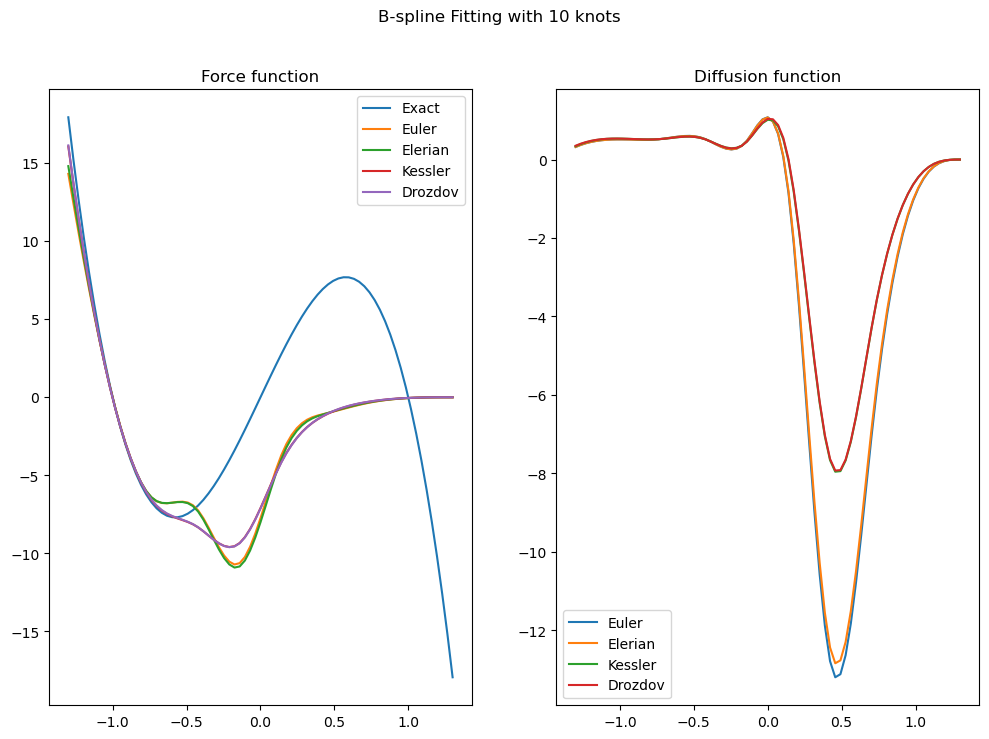

In [96]:
n_knots =10
domain = fl.MeshedDomain.create_from_range(np.linspace(min(xfa) , max(xfa) , n_knots).ravel())  # n_knots is improperly the number of knots 
trainmodelx = fl.models.OverdampedSplines1D(domain=domain)

res_vec=[]
fig, axs = plt.subplots(1, 2,figsize=(12,8))
axs[0].plot(xfa,xforce, label="Exact")
names = ["Euler", "Elerian","Kessler", "Drozdov"]

for name, transitioncls in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"],#"Ozaki", "ShojiOzaki", "Elerian", "Kessler", "Drozdov"],
    [
        fl.EulerDensity,
        # fl.OzakiDensity,
        # fl.ShojiOzakiDensity,
        fl.ElerianDensity,
        fl.KesslerDensity,
        fl.DrozdovDensity,
    ],
):
    estimator = fl.LikelihoodEstimator(transitioncls(deepcopy(trainmodelx)))
    res = estimator.fit_fetch(xdata)
    print(res.coefficients)
    res_vec.append(res)
    axs[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    axs[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
axs[0].set_title('Force function')
axs[1].set_title('Diffusion function')
axs[0].legend()
axs[1].legend()
fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')


/home/dbersano/folie/folie/estimation/transitionDensity.py:20: RuntimeWarning: invalid value encountered in log
  ll = -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)


[ 1.09511110e+01  9.70043413e+00 -3.56571256e+00 -5.22842122e+00
 -1.09944160e+01 -6.49093259e+00 -1.16319961e+01 -5.55673817e-01
  9.69206469e-01 -1.14663873e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.46284384e-01
  4.53596625e-01  5.74853548e-01  4.34915456e-01  7.51943748e-01
  5.36267387e-01 -2.66916716e-01  3.24365340e+00 -8.35540426e+00
  5.52296177e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


/home/dbersano/folie/folie/estimation/transitionDensity.py:11: RuntimeWarning: invalid value encountered in log
  return -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)


[ 1.07264155e+01  1.00128008e+01 -3.75498060e+00 -5.13289412e+00
 -1.04901542e+01 -6.74463385e+00 -1.12269736e+01 -6.35487905e-01
  8.77213444e-01 -1.14825380e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.45193674e-01
  4.53733079e-01  5.74741965e-01  4.34986587e-01  7.50689211e-01
  5.39256707e-01 -2.80645912e-01  3.35706243e+00 -8.66047554e+00
  5.52350486e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[ 8.80316502e+00  1.10000082e+01 -4.29787995e+00 -4.90913785e+00
 -8.65344633e+00 -9.80426830e+00 -8.98840767e+00 -6.11670745e-01
  1.80002519e-01 -1.14775955e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.08566912e-01
  4.86669640e-01  6.06776937e-01  4.18993258e-01  7.97942136e-01
  5.01329805e-01 -2.65394341e-01  3.48690101e+00 -9.39552276e+00
  5.52165926e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[ 9.12109339e+00  1.08

Text(0.5, 0.98, 'B-spline Fitting with 15 knots')

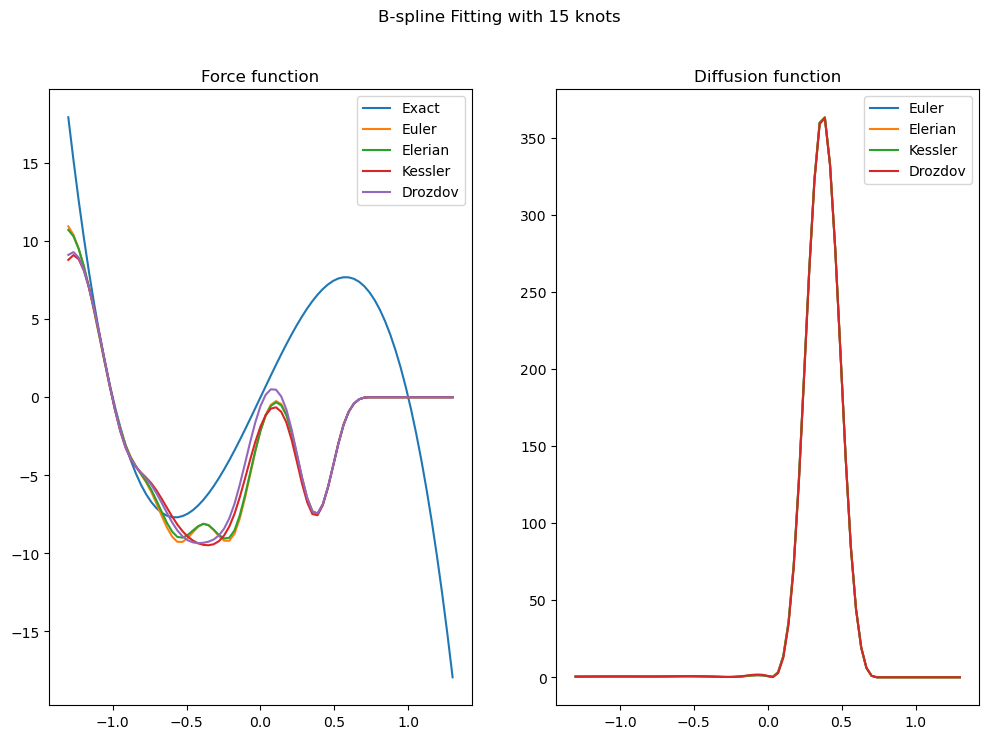

In [97]:
n_knots =15
domain = fl.MeshedDomain.create_from_range(np.linspace(min(xfa) , max(xfa) , n_knots).ravel())  # n_knots is improperly the number of knots 
trainmodelx = fl.models.OverdampedSplines1D(domain=domain)

res_vec=[]
fig, axs = plt.subplots(1, 2,figsize=(12,8))
axs[0].plot(xfa, xforce, label="Exact")

# model_simu.remove_bias()
for name, transitioncls in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"],#"Ozaki", "ShojiOzaki", "Elerian", "Kessler", "Drozdov"],
    [
        fl.EulerDensity,
        # fl.OzakiDensity,
        # fl.ShojiOzakiDensity,
        fl.ElerianDensity,
        fl.KesslerDensity,
        fl.DrozdovDensity,
    ],
):
    estimator = fl.LikelihoodEstimator(transitioncls(deepcopy(trainmodelx)))
    res = estimator.fit_fetch(xdata)
    print(res.coefficients)
    res_vec.append(res)
    # res.remove_bias()
    axs[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    axs[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
axs[0].set_title('Force function')
axs[1].set_title('Diffusion function')
axs[0].legend()
axs[1].legend()
fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')


[  6.8477615   11.19845863   2.01567142  -4.19965802  -5.23784093
  -9.61304764  -9.5311783   -6.87760346 -11.07730227  -4.58628635
  -3.5688755   -1.87429098   0.           0.           0.
   0.           0.           0.           0.           0.
   0.39691049   0.47518185   0.51011128   0.52289636   0.46233469
   0.51284856   1.01525721   0.20513218   0.06392197   2.13841598
  -1.20264731   9.12461786   0.           0.           0.
   0.           0.           0.           0.           0.        ]
[ 5.01138508 12.01071643  1.67437921 -4.07005849 -5.70003424 -7.49853307
 -7.22800154 -9.09312818 -8.66331698 -3.1126051  -2.166613   -1.1171692
  0.          0.          0.          0.          0.          0.
  0.          0.          0.43651171  0.46441378  0.51407785  0.52121875
  0.46250811  0.52939685  0.95765035  0.25646809 -0.02061633  2.67970509
 -2.16869096 15.221361    0.          0.          0.          0.
  0.          0.          0.          0.        ]
[  6.52834471  11.239337

Text(0.5, 0.98, 'B-spline Fitting with 20 knots')

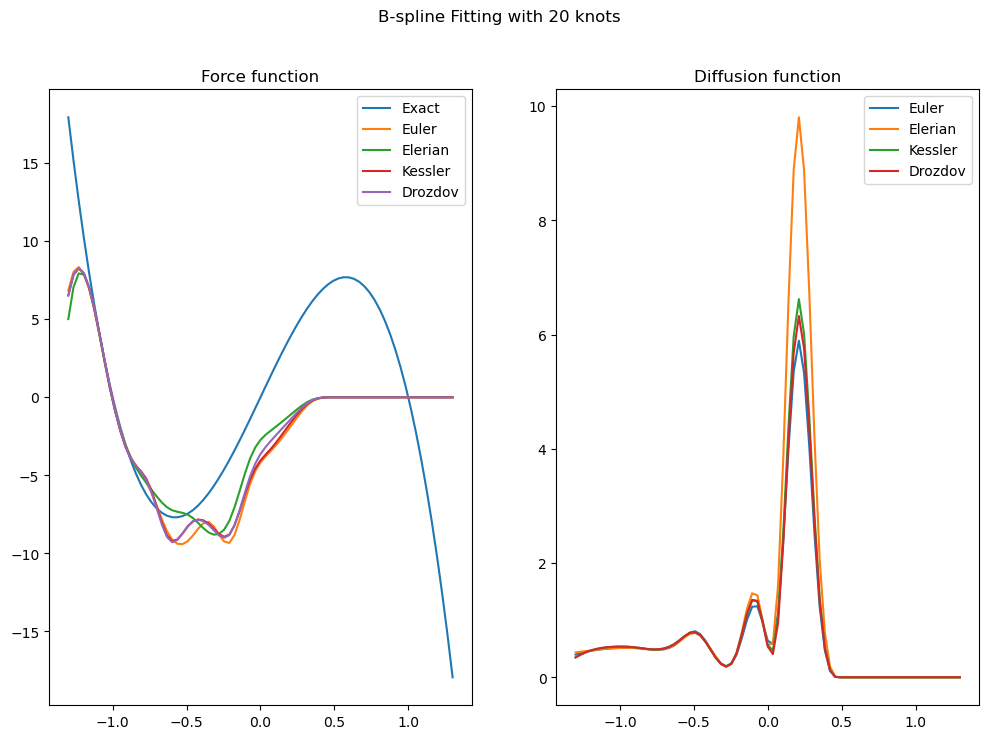

In [102]:
n_knots =20
domain = fl.MeshedDomain.create_from_range(np.linspace(min(xfa) , max(xfa) , n_knots).ravel())  # n_knots is improperly the number of knots 
trainmodelx = fl.models.OverdampedSplines1D(domain=domain)

res_vec=[]
fig, axs = plt.subplots(1, 2,figsize=(12,8))
axs[0].plot(xfa, xforce, label="Exact")

# model_simu.remove_bias()
for name, transitioncls in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"],#"Ozaki", "ShojiOzaki", "Elerian", "Kessler", "Drozdov"],
    [
        fl.EulerDensity,
        # fl.OzakiDensity,
        # fl.ShojiOzakiDensity,
        fl.ElerianDensity,
        fl.KesslerDensity,
        fl.DrozdovDensity,
    ],
):
    estimator = fl.LikelihoodEstimator(transitioncls(deepcopy(trainmodelx)))
    res = estimator.fit_fetch(xdata)
    print(res.coefficients)
    res_vec.append(res)
    # res.remove_bias()
    axs[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    axs[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
axs[0].set_title('Force function')
axs[1].set_title('Diffusion function')
axs[0].legend()
axs[1].legend()
fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')


In [57]:
# SMALL CHECK
for i in range(len(res_vec)-1):
    flag_force= (res_vec[i].force(xfa.reshape(-1, 1)) == res_vec[i+1].force(xfa.reshape(-1, 1))).all()
    flag_diff= (res_vec[i].diffusion(xfa.reshape(-1, 1)) == res_vec[i+1].diffusion(xfa.reshape(-1, 1))).all()
    print(flag_force, flag_diff)  # apparently they are 
plt.show()

False False
False False
False False


### 3.2) Projection onto y coordinate

In [91]:
ydata = fl.data.trajectories.Trajectories(dt=dt) 
s = np.empty(shape=(len(trj["x"][:,1]),1))
for n, trj in enumerate(data):
    for j in range(len(trj["x"][:,1])):
        s[j]=trj["x"][:,1][j]
    ydata.append(s)
print(len(s))
# #### Possible models 
# trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
# traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
# trainmodelx=fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=False)
yfa = np.linspace(-1.3, 1.3, 75)
yforce= -b*yfa

4999


#### 3.2.1) Fitting with exact  Ornstein–Uhlenbeck model

Text(0.5, 0.98, ' Ornstein–Uhlenbeck Fitting along y direction')

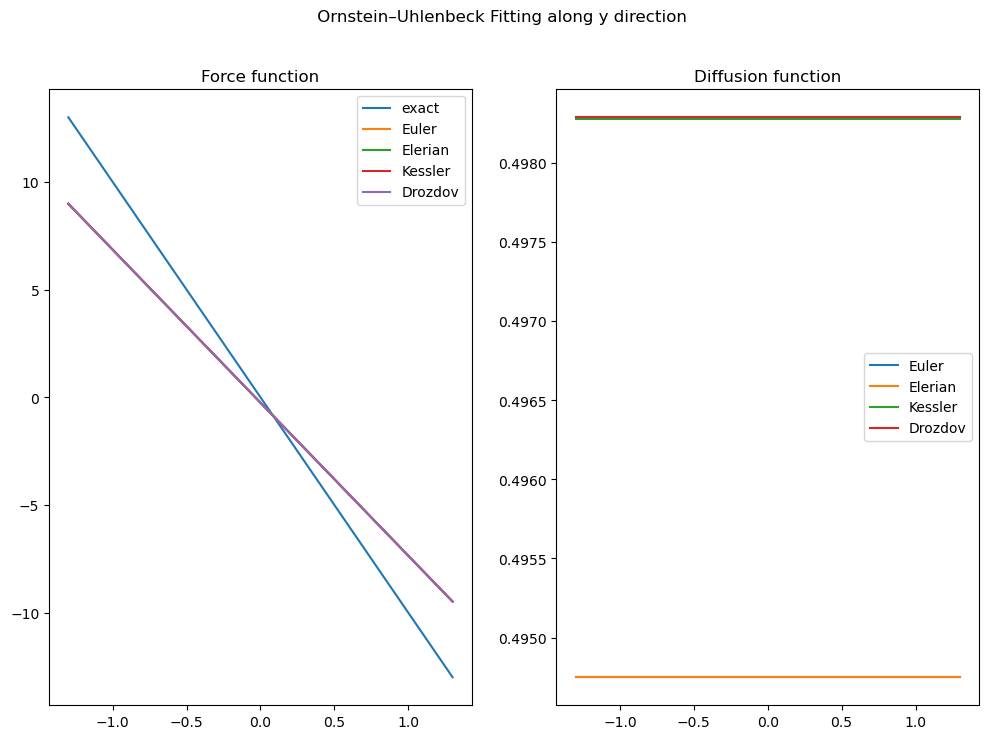

In [94]:
trainmodel=fl.models.OrnsteinUhlenbeck(has_bias=False)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))   # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel))) # and when the second estimator uses the object trainmodel this will already have the modfications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel))) # made by the previuos estimatorand so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel))) # which is the reason why the loop checking if the values are different in the following cell exists


Eul_res=Eul_estimator.fit_fetch(ydata)
Eln_res=Eln_estimator.fit_fetch(ydata)
Ksl_res=Ksl_estimator.fit_fetch(ydata)
Drz_res=Drz_estimator.fit_fetch(ydata)

res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(12,8))
ax[0].plot(yfa, yforce,label='exact')
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(yfa, res.force(yfa.reshape(-1, 1)), label=name)
    ax[1].plot(yfa, res.diffusion(yfa.reshape(-1, 1)), label=name)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle(' Ornstein–Uhlenbeck Fitting along y direction')

In [93]:
for res in res_vec:
    print(res.coefficients)

[-0.25079384 -7.10405312  0.49474915]
[-0.25079384 -7.10405312  0.49474915]
[-0.25079355 -7.10405214  0.49827678]
[-0.25079384 -7.10405225  0.49828917]


### 3.3) Projecting onto $1^{st}$ and $3^{rd}$ quadrant bisectrix

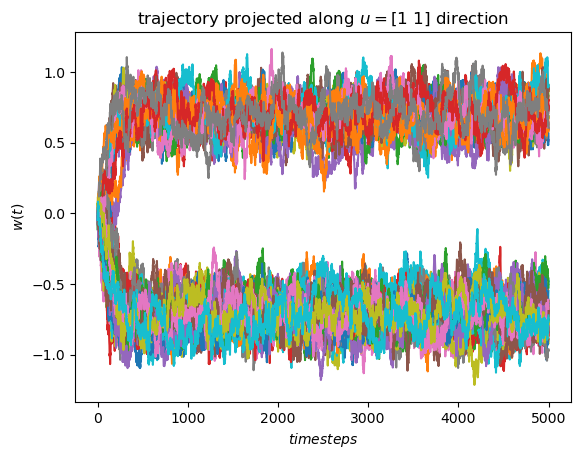

In [59]:
u = np.array([1,1])
u_norm= (1/np.linalg.norm(u,2))*u
w = np.empty(shape=(len(trj["x"]),1))

proj_data = fl.data.trajectories.Trajectories(dt=dt) # create new Trajectory object in which to store the projected trajectory dictionaries

fig, axs =plt.subplots()
for n, trj in enumerate(data):
    for i in range(len(trj["x"])):
        w[i]=np.dot(trj["x"][i],u_norm)
    proj_data.append(w)
    axs.plot(proj_data[n]["x"])
    axs.set_xlabel("$timesteps$")
    axs.set_ylabel("$w(t)$")
    axs.set_title("trajectory projected along $u =$"  + str(u) + " direction")
    axs.grid()

#### 3.3.1) Fitting with splines

Text(0.5, 0.98, 'B-spline Fitting with 10 knots')

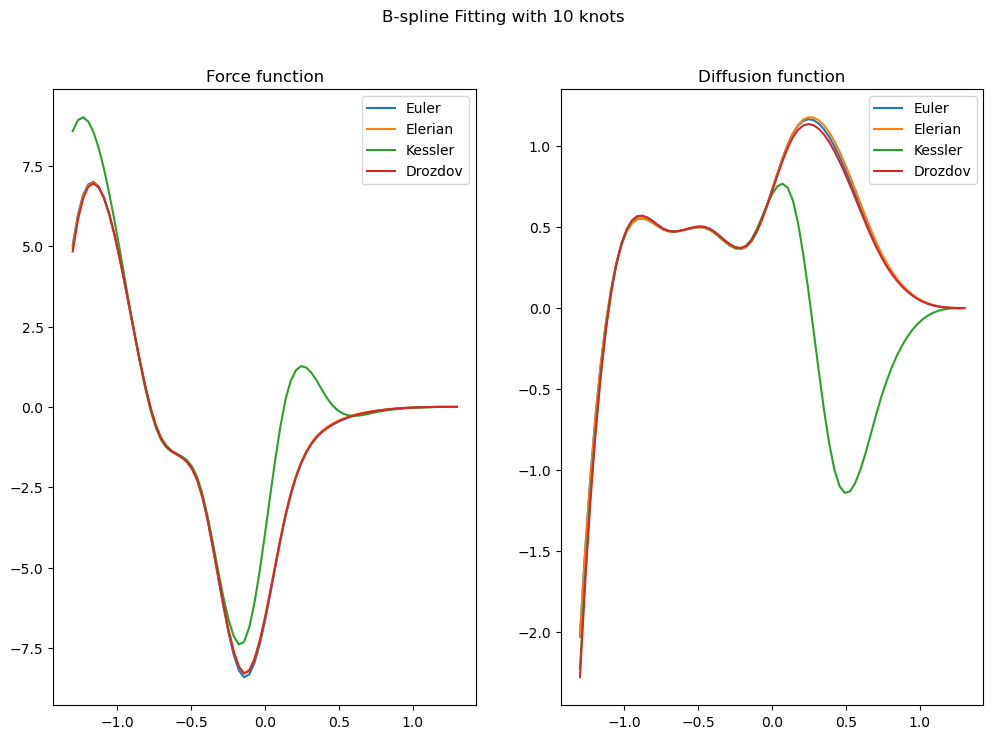

In [76]:
n_knots=10
xfa = np.linspace(-1.3, 1.3, 75)
domain = fl.MeshedDomain.create_from_range(np.linspace(min(xfa) , max(xfa) , n_knots).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))  # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))  # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel))) # made by the previuos estimator and so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel))) # which is the reason why the loop checking if the values are different in the following cell exists

Eul_res=Eul_estimator.fit_fetch(proj_data)
Eln_res=Eln_estimator.fit_fetch(proj_data)
Ksl_res=Ksl_estimator.fit_fetch(proj_data)
Drz_res=Drz_estimator.fit_fetch(proj_data)

res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(12,8))
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')


Text(0.5, 0.98, 'B-spline Fitting with 15 knots')

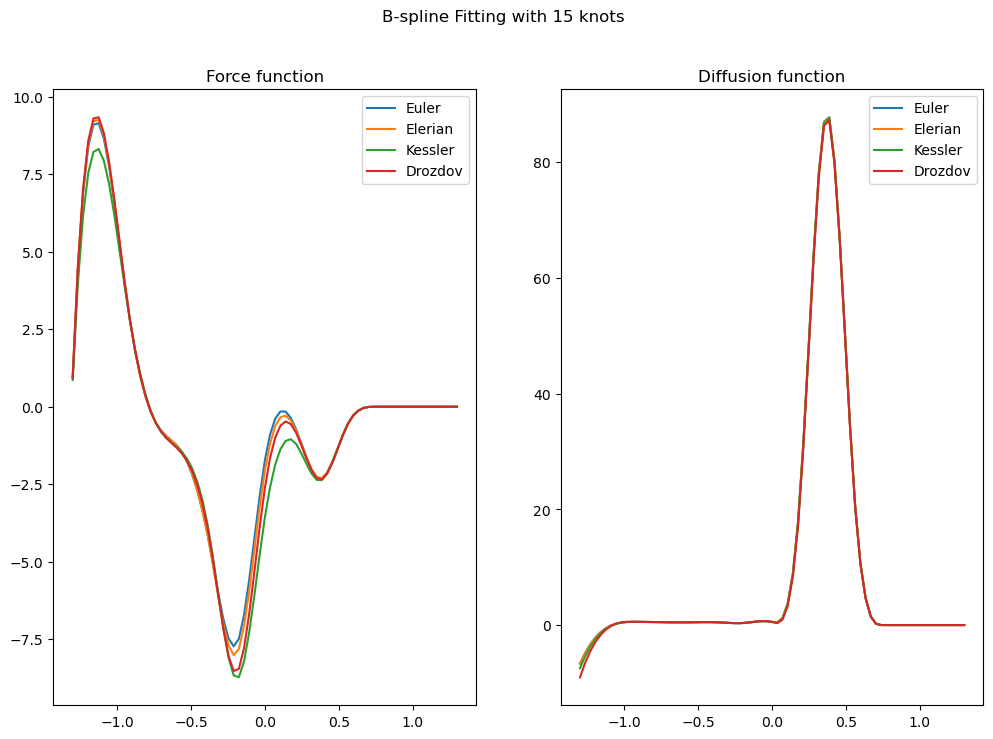

In [74]:
n_knots=15
xfa = np.linspace(-1.3, 1.3, 75)
domain = fl.MeshedDomain.create_from_range(np.linspace(min(xfa) , max(xfa) , n_knots).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))  # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))  # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel))) # made by the previuos estimator and so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel))) # which is the reason why the loop checking if the values are different in the following cell exists

Eul_res=Eul_estimator.fit_fetch(proj_data)
Eln_res=Eln_estimator.fit_fetch(proj_data)
Ksl_res=Ksl_estimator.fit_fetch(proj_data)
Drz_res=Drz_estimator.fit_fetch(proj_data)

res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(12,8))
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')

Text(0.5, 0.98, 'B-spline Fitting with 20 knots')

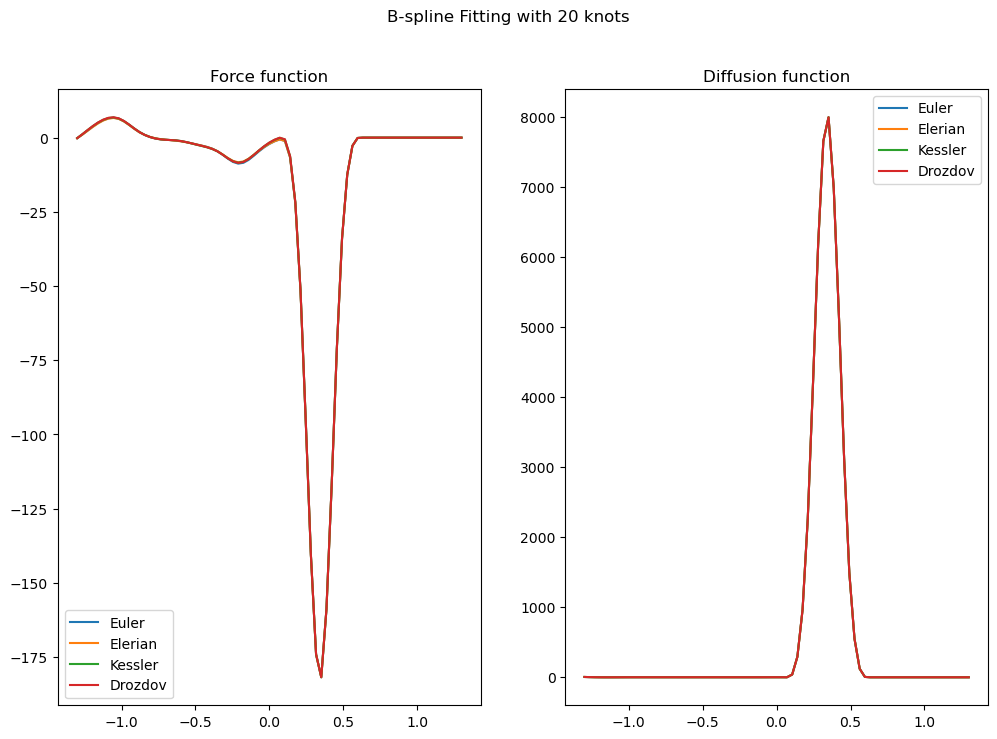

In [75]:
n_knots=20
xfa = np.linspace(-1.3, 1.3, 75)
domain = fl.MeshedDomain.create_from_range(np.linspace(min(xfa) , max(xfa) , n_knots).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))  # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))  # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel))) # made by the previuos estimator and so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel))) # which is the reason why the loop checking if the values are different in the following cell exists

Eul_res=Eul_estimator.fit_fetch(proj_data)
Eln_res=Eln_estimator.fit_fetch(proj_data)
Ksl_res=Ksl_estimator.fit_fetch(proj_data)
Drz_res=Drz_estimator.fit_fetch(proj_data)

res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(12,8))
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')

# 2D BIASED Double Well Potential

attempt ornstein uhlembeck
==

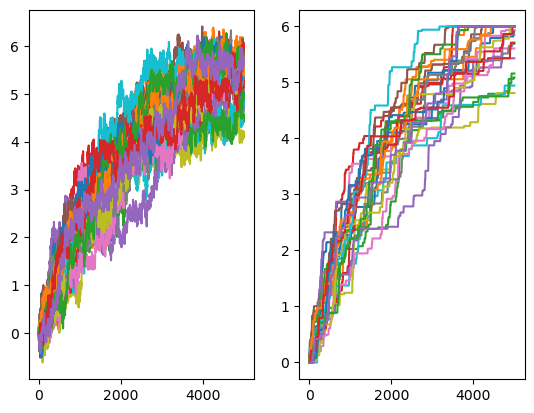

In [ ]:

model_simu = fl.models.OrnsteinUhlenbeck(0.0, 1.2, 2.0)
simulator = fl.simulations.ABMD_Simulator(fl.simulations.EulerStepper(model_simu), 1e-3, k=10.0, xstop=6.0)
data = simulator.run(5000, np.zeros((25,)), 1)
xmax = np.concatenate(simulator.xmax_hist, axis=1).T

# Plot the resulting trajectories
# sphinx_gallery_thumbnail_number = 1
fig, axs = plt.subplots(1, 2)
for n, trj in enumerate(data):
    axs[0].plot(trj["x"])
    axs[1].plot(xmax[:, n])

In [ ]:

# model_simu = fl.models.OrnsteinUhlenbeck(0.0, 1.2, 2.0)
# simulator = fl.simulations.ABMD_Simulator(fl.simulations.EulerStepper(model_simu), 1e-3, k=10.0, xstop=6.0)
# data = simulator.run(5000, np.zeros((25,)), 1)
# xmax = np.concatenate(simulator.xmax_hist, axis=1).T
# model_simu.remove_bias()
trainmodel=fl.models.OrnsteinUhlenbeck(has_bias=True)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))  # deepcopy is used because the estimator modifies the model when fit method is called
Ozk_estimator = fl.LikelihoodEstimator(fl.OzakiDensity(deepcopy(trainmodel)))  # and when the second estimator uses the object trainmodel this will already have the modfications
Shj_estimator = fl.LikelihoodEstimator(fl.ShojiOzakiDensity(deepcopy(trainmodel))) # made by the previuos estimatorand so in the end they will return the exact same results
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))  # which is the reason why the loop checking if the values are different in the following cell exists
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel)))
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel)))

Eul_res=Eul_estimator.fit_fetch(data)
Ozk_res=Ozk_estimator.fit_fetch(data)
Shj_res=Shj_estimator.fit_fetch(data)
Eln_res=Eln_estimator.fit_fetch(data)
Ksl_res=Ksl_estimator.fit_fetch(data)
Drz_res=Drz_estimator.fit_fetch(data)

res_vec = [Eul_res,Ozk_res,Shj_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 


RecursionError: maximum recursion depth exceeded